In [1]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
import nn_utils

# Task 1

In [2]:
numu = pd.read_csv('numu_energy_studies.csv') # Read in the files

In [3]:
# This looks good but I've dropped NaNs as I spotted a few
numu.dropna(inplace=True)
numu.head(5)

,Unnamed: 0,i,neutrinoE,trueKE,recoE_lookup,total_PMTs_hits2,total_hits2,total_ring_PEs2,pot_length2,hits_pot_length2,recoDWallR2,recoDWallZ2,lambda_max_2,recoDWall_2,recoToWall_2,vtxTrackBias_2
0,0,0,664.541,236.327,22.35380,0.000000,0.023325,0.00000,0.662787,0.003754,0.003389,0.458415,0.650854,0.003389,0.220977,-0.011905
1,1,3,400.551,186.765,2.46971,0.000000,0.010075,0.00000,0.662787,0.001621,0.003389,0.458415,0.405903,0.003389,0.220977,-2.269040
2,2,4,633.353,448.481,409.95400,0.308444,0.080400,0.13070,0.531171,0.016146,0.035389,0.753969,0.537975,0.035389,0.494926,0.024453
3,3,7,845.921,586.647,37.83740,0.000000,0.011950,0.00000,0.918554,0.001388,0.042498,0.083664,0.830098,0.042498,0.805578,-0.007114
4,4,9,1323.140,963.822,1408.07000,0.111333,0.142300,0.26265,0.093641,0.162093,0.616305,0.164307,0.092105,0.358487,0.135845,-0.004307


In [4]:
print(numu.shape) # Shape looks good so NaN dropping is successfull

(163592, 16)


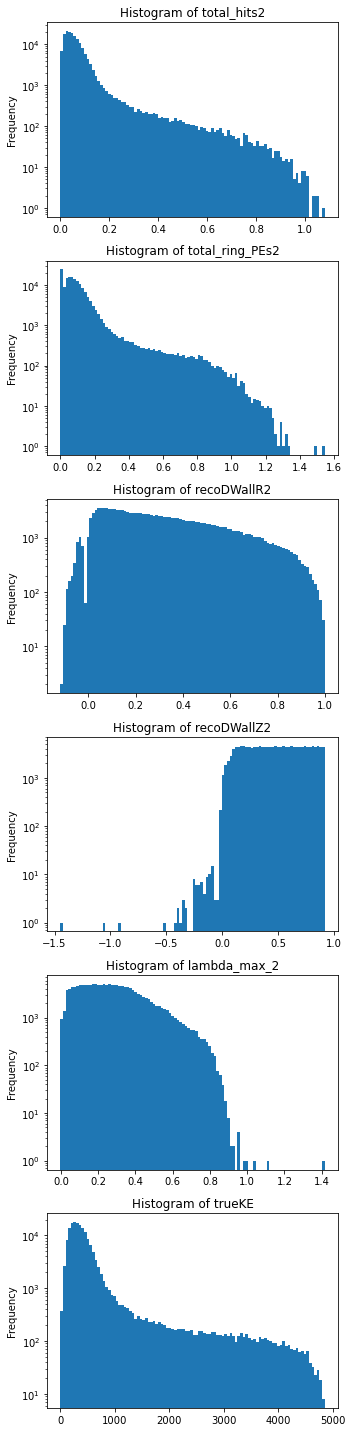

In [5]:
# Plotting the features

# These are the features we want
features = ["total_hits2","total_ring_PEs2","recoDWallR2","recoDWallZ2","lambda_max_2","trueKE"]

#plot histograms of the features
fig,ax = plt.subplots(6,figsize=(5,20))
for i in range(len(features)):
    ax[i].hist(numu[features[i]],bins=100,log=True)
    ax[i].set_title("Histogram of {}".format(features[i]))
    ax[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The true kinetic energy has a similar distribution shape as the number of time-coincidence hits and the number of hits assigned to Cerenkov rings.

# Task 2

In [6]:
# Preparing the datasets

input_data = numu[["total_hits2","total_ring_PEs2","recoDWallR2","recoDWallZ2","lambda_max_2"]] # input data
target = numu["trueKE"] # target data


Answer_to_all_questions = 42
# train-test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(\
input_data, target, test_size = 0.3, random_state = Answer_to_all_questions) 
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape) # This corresponds to 70% and 30% split

(114514, 5) (114514,) (49078, 5) (49078,)


In [7]:
def my_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes,input_dim = num_inputs,kernel_initializer = 'normal',\
    activation ='relu'))
    model.add(Dropout(0.1)) # Decrease the amount of dropout as it affects performance
    model.add(Dense(num_nodes,input_dim = num_nodes,kernel_initializer = 'normal',\
    activation ='relu')) # Increase the width of each layer by a factor 25 (125 nodes)
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs,kernel_initializer ='normal'))
    # Compile model with mean squared error loss function
    model.compile(loss = 'mean_squared_error', optimizer ='adam')
    return model


callbacks_ = [
# If we don't have an increase of the accuracy for 10 epochs, terminate training.
EarlyStopping (verbose = True, patience = 10, monitor = 'loss'),
# Always make sure that we're saving the model weights with the best accuracy.
ModelCheckpoint('model.h5', monitor = 'loss', verbose = 0 ,save_best_only = True, mode = 'max')]

In [8]:
batchSize = 512 # Use a large batch size
N_epochs = 50 # 50 epochs
num_nodes = 20 # layer size of 20
num_outputs = 1
num_inputs = 5

Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn = my_model, epochs = N_epochs,
batch_size = batchSize, verbose = 1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits = 10, random_state = Answer_to_all_questions, shuffle = True)
results = cross_val_score(pipeline, train_data, train_target, cv = kfold,
fit_params = {'mlp__callbacks': callbacks_} ,scoring ='r2')
print("Result: %.2f %s %.2f" %(results.mean(), u"\u00B1", results.std())) 
#The R^2 value of 0.73 is acceptable

C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
202/202 [==============================] - 1s 2ms/step - loss: 636143.3125
Epoch 2/50
202/202 [==============================] - 0s 1ms/step - loss: 569396.4375
Epoch 3/50
202/202 [==============================] - 0s 1ms/step - loss: 413020.5938
Epoch 4/50
202/202 [==============================] - 0s 1ms/step - loss: 328424.2812
Epoch 5/50
202/202 [==============================] - 0s 1ms/step - loss: 308208.9375
Epoch 6/50
202/202 [==============================] - 0s 2ms/step - loss: 292180.9688
Epoch 7/50
202/202 [==============================] - 0s 2ms/step - loss: 271181.1875
Epoch 8/50
202/202 [==============================] - 0s 1ms/step - loss: 244356.5469
Epoch 9/50
202/202 [==============================] - 0s 2ms/step - loss: 210607.3750
Epoch 10/50
202/202 [==============================] - 0s 2ms/step - loss: 174375.1250
Epoch 11/50
202/202 [==============================] - 0s 2ms/step - loss: 146271.9219
Epoch 12/50
202/202 [==============================]

202/202 [==============================] - 0s 1ms/step - loss: 112159.0156
Epoch 45/50
202/202 [==============================] - 0s 1ms/step - loss: 111374.2344
Epoch 46/50
202/202 [==============================] - 0s 1ms/step - loss: 112377.7422
Epoch 47/50
202/202 [==============================] - 0s 1ms/step - loss: 111653.0938
Epoch 48/50
202/202 [==============================] - 0s 1ms/step - loss: 111057.1016
Epoch 49/50
202/202 [==============================] - 0s 1ms/step - loss: 111452.1719: 0s - loss: 10922
Epoch 50/50
23/23 [==============================] - 0s 959us/step
Epoch 1/50
202/202 [==============================] - 1s 1ms/step - loss: 635946.8750
Epoch 2/50
202/202 [==============================] - 0s 1ms/step - loss: 534036.1875
Epoch 3/50
202/202 [==============================] - 0s 1ms/step - loss: 363624.1875
Epoch 4/50
202/202 [==============================] - 0s 1ms/step - loss: 315238.0000
Epoch 5/50
202/202 [==============================] - 0s 1ms/

202/202 [==============================] - 0s 1ms/step - loss: 111164.3594
Epoch 37/50
202/202 [==============================] - 0s 1ms/step - loss: 112312.3594
Epoch 38/50
202/202 [==============================] - 0s 1ms/step - loss: 112303.8750
Epoch 39/50
202/202 [==============================] - 0s 1ms/step - loss: 111035.6406
Epoch 40/50
202/202 [==============================] - 0s 1ms/step - loss: 111185.2266
Epoch 41/50
202/202 [==============================] - 0s 1ms/step - loss: 111271.7344
Epoch 42/50
202/202 [==============================] - 0s 1ms/step - loss: 110606.9453
Epoch 43/50
202/202 [==============================] - 0s 1ms/step - loss: 110734.3125
Epoch 44/50
202/202 [==============================] - 0s 1ms/step - loss: 110051.1562
Epoch 45/50
202/202 [==============================] - 0s 1ms/step - loss: 109815.6719
Epoch 46/50
202/202 [==============================] - 0s 1ms/step - loss: 110025.4062
Epoch 47/50
202/202 [==============================] - 

202/202 [==============================] - 0s 1ms/step - loss: 113035.6875
Epoch 30/50
202/202 [==============================] - 0s 1ms/step - loss: 113096.5078
Epoch 31/50
202/202 [==============================] - 0s 1ms/step - loss: 111957.1094
Epoch 32/50
202/202 [==============================] - 0s 1ms/step - loss: 111890.5156
Epoch 33/50
202/202 [==============================] - 0s 1ms/step - loss: 111991.7500
Epoch 34/50
202/202 [==============================] - 0s 1ms/step - loss: 111396.9844
Epoch 35/50
202/202 [==============================] - 0s 1ms/step - loss: 111778.5547
Epoch 36/50
202/202 [==============================] - 0s 1ms/step - loss: 111603.7891
Epoch 37/50
202/202 [==============================] - 0s 1ms/step - loss: 111217.4375
Epoch 38/50
202/202 [==============================] - 0s 1ms/step - loss: 111810.6562
Epoch 39/50
202/202 [==============================] - 0s 1ms/step - loss: 111116.7422
Epoch 40/50
202/202 [==============================] - 

202/202 [==============================] - 0s 1ms/step - loss: 112526.8203
Epoch 22/50
202/202 [==============================] - 0s 1ms/step - loss: 112498.4766
Epoch 23/50
202/202 [==============================] - 0s 1ms/step - loss: 112725.5078
Epoch 24/50
202/202 [==============================] - 0s 1ms/step - loss: 111982.7031
Epoch 25/50
202/202 [==============================] - 0s 1ms/step - loss: 111244.9453
Epoch 26/50
202/202 [==============================] - 0s 1ms/step - loss: 111822.0938
Epoch 27/50
202/202 [==============================] - 0s 1ms/step - loss: 111302.7969
Epoch 28/50
202/202 [==============================] - 0s 1ms/step - loss: 111603.4219
Epoch 29/50
202/202 [==============================] - 0s 1ms/step - loss: 111048.9141
Epoch 30/50
202/202 [==============================] - 0s 1ms/step - loss: 110991.7500
Epoch 31/50
202/202 [==============================] - 0s 1ms/step - loss: 111004.0625
Epoch 32/50
202/202 [==============================] - 

202/202 [==============================] - 0s 1ms/step - loss: 114590.3906
Epoch 14/50
202/202 [==============================] - 0s 1ms/step - loss: 113631.9609
Epoch 15/50
202/202 [==============================] - 0s 1ms/step - loss: 112998.0000
Epoch 16/50
202/202 [==============================] - 0s 1ms/step - loss: 112722.6250
Epoch 17/50
202/202 [==============================] - 0s 1ms/step - loss: 112439.7578
Epoch 18/50
202/202 [==============================] - 0s 1ms/step - loss: 112407.9141
Epoch 19/50
202/202 [==============================] - 0s 1ms/step - loss: 111669.9375
Epoch 20/50
202/202 [==============================] - 0s 1ms/step - loss: 112029.4453
Epoch 21/50
202/202 [==============================] - 0s 1ms/step - loss: 112873.3125
Epoch 22/50
202/202 [==============================] - 0s 1ms/step - loss: 112091.3594
Epoch 23/50
202/202 [==============================] - 0s 1ms/step - loss: 110984.2266
Epoch 24/50
202/202 [==============================] - 

In [9]:
backend.clear_session() #Clear excess data to save memory and speed up running
model=my_model() # Define the model
history=model.fit(train_data,train_target,epochs=N_epochs,batch_size=batchSize,callbacks=callbacks_,\
                 validation_data=(test_data, test_target))

Epoch 1/50
224/224 [==============================] - 1s 2ms/step - loss: 631469.0625 - val_loss: 602057.4375
Epoch 2/50
224/224 [==============================] - 0s 2ms/step - loss: 512015.2500 - val_loss: 401103.0000
Epoch 3/50
224/224 [==============================] - 0s 2ms/step - loss: 347138.9375 - val_loss: 312450.1250
Epoch 4/50
224/224 [==============================] - 0s 2ms/step - loss: 309692.2812 - val_loss: 292355.6250
Epoch 5/50
224/224 [==============================] - 0s 2ms/step - loss: 288079.3125 - val_loss: 267986.2812
Epoch 6/50
224/224 [==============================] - 0s 2ms/step - loss: 260209.0781 - val_loss: 234711.6562
Epoch 7/50
224/224 [==============================] - 0s 2ms/step - loss: 221979.5938 - val_loss: 190791.2656
Epoch 8/50
224/224 [==============================] - 0s 2ms/step - loss: 177189.4688 - val_loss: 145909.8438
Epoch 9/50
224/224 [==============================] - 0s 2ms/step - loss: 140612.8438 - val_loss: 118673.8672
Epoch 10/5

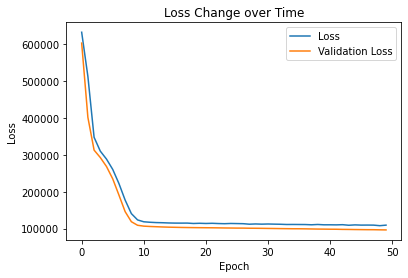

In [10]:
# Plot the loss curves
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("Loss Change over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

This graph shows that overtraining does not occur as the loss function does not increase. However, the loss doesn't really change much after 15 epochs so the early stopping could have been made more stringent and not much effect would have occured.

In [11]:
# Use the model to predict energies
prediction = model.predict(test_data) 

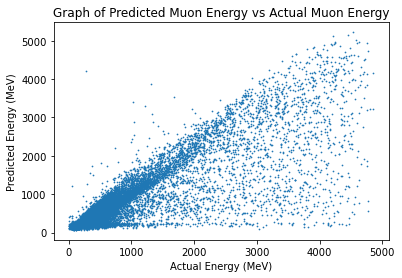

In [12]:
# Plot the predicted energy vs predicted energy

plt.scatter(test_target,prediction,s=0.5)
plt.title("Graph of Predicted Muon Energy vs Actual Muon Energy")
plt.xlabel("Actual Energy (MeV)")
plt.ylabel("Predicted Energy (MeV)")
plt.show()

The prediction is reasonably good at low energies but at high energies the x=y line virtually disappears. Most energies are underpredicted, rather than overpredicted, as the points are mainly below the diagonal x=y line. 

# Task 3

In [13]:
gbr0 = GradientBoostingRegressor(n_estimators=100) #Create the GBR
gbr0.fit(train_data, train_target.ravel()) # Fit the GBR model to the data

r2_train = gbr0.score(train_data,train_target) #Determine the R^2 values
r2_test = gbr0.score(test_data,test_target)
print("R^2 of testing data = {}".format(r2_test))
print("R^2 of training data = {}".format(r2_train))

R^2 of testing data = 0.781797050479113
R^2 of training data = 0.7830727956686763


These scores are better than the regressor by around 5%. It therefore appears that a gradient boosting regressor is working better than the neural network.

In [14]:
# Look for the best parameters via a parameter search

# Define the parameter grid to be tested
param_grid_ = {
'n_estimators':[100],
'learning_rate':[0.1, 0.05],
'max_depth':[5, 10],
'min_samples_leaf':[50,100],
}

njobs_ = 8 # jobs to run in parallel
np.random.seed(Answer_to_all_questions)
gbr = GradientBoostingRegressor()
# Use HalvingGridSearch to speed up the process
classifier = HalvingGridSearchCV(estimator = gbr,cv = kfold, param_grid=param_grid_,
                            verbose=1,n_jobs=njobs_) # Define the grid search parameters

classifier.fit(train_data, train_target.ravel())


print("Best estimator:")
print(classifier.best_estimator_)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 38171
max_resources_: 114514
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 38171
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 3
n_resources: 114513
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best estimator:
GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)


The best estimator has a learning rate of 0.05, a max depth of 10 and a minimum number of samples per leaf of 50.

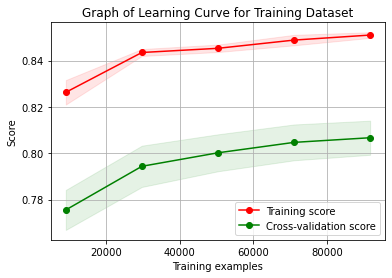

In [15]:
# Plotting the learn functions for training dataset

title_train = "Graph of Learning Curve for Training Dataset"

nn_utils.plot_learning_curve(classifier.best_estimator_, title_train, train_data, train_target, ylim=None, cv=None, n_jobs=8,
                        train_sizes=np.linspace(.1, 1.0, 5)) # Using the import to plot the curve
plt.show()

The training score is superior to the cross-validation implying there is some overfitting going on but an $R^2$ value of above 0.8 makes this better than the neural network.

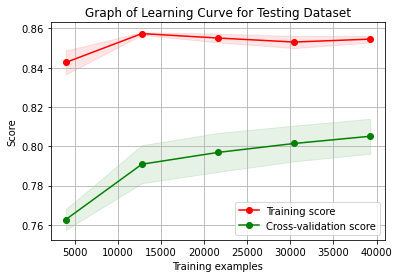

In [16]:
# Plotting the learn functions for testing dataset

title_test = "Graph of Learning Curve for Testing Dataset"

nn_utils.plot_learning_curve(classifier.best_estimator_, title_test, test_data, test_target, ylim=None, cv=None, n_jobs=8,
                        train_sizes=np.linspace(.1, 1.0, 5)) # Using the import to plot the curve
plt.show()

This testing score is comparable to the training score although the cross validation starts off slightly worse and is a tiny bit lower than for the training dataset. This is to be expected, however, as the model was not trained on this dataset. On top of that, the score is still higher for this than for the neural network so the GBR is better.

In [17]:
#Create new GBR with optimum parameters

best_depth = classifier.best_estimator_.max_depth # Best depth
best_samples = classifier.best_estimator_.min_samples_leaf # Best number of samples per leaf node
best_estimators = classifier.best_estimator_.n_estimators # Best number of estimators
best_learning_rate = classifier.best_estimator_.learning_rate # Best learning rate

gbr1 = GradientBoostingRegressor(max_depth=best_depth,min_samples_leaf=best_samples,n_estimators=best_estimators,\
                                learning_rate=best_learning_rate)
best_results = cross_val_score(gbr1,train_data, train_target, cv = kfold, scoring='r2',n_jobs=8)
print("R^2 result: %.4f %s %.4f" %(best_results.mean(), u"\u00B1", best_results.std()))

R^2 result: 0.8062 ± 0.0124


This is a very good $R^2$ result that is about 2% higher than for the un-optimised GBR -- even with the (small) standard deviation taken into account. 

In [ ]:
# Train the model by fitting to training data
history_gbr1 = gbr1.fit(train_data,train_target)

In [ ]:
# Test the model on the testing data
prediction_gbr1 = gbr1.predict(test_data)

In [ ]:
# Plot the predicted energy vs predicted energy

plt.scatter(test_target,prediction_gbr1,s=0.5)
plt.title("Graph of Predicted Muon Energy vs Actual Muon Energy via GBR")
plt.xlabel("Actual Energy (MeV)")
plt.ylabel("Predicted Energy (MeV)")
plt.show()

This prediction is much better than the one from the regression neural network as there is better defined x=y line. Especially at higher energies, the regression is better giving a more distinct line. Again, like the neural network, it too underpredicts the energies more often.

In [ ]:
#Ordering feature importances by weight

importance = list(gbr1.feature_importances_) # Feauture importances by weight
feats = ["total_hits2","total_ring_PEs2","recoDWallR2","recoDWallZ2","lambda_max_2"] # list of features
print("Order of Feature Importances by Weight:\n")

for i in range(5):
    print("{}: {:.4f}".format(feats[np.argmax(importance)],importance[np.argmax(importance)])) #Print the highest
    feats.pop(np.argmax(importance)) # Remove the highest from the list
    importance.pop(np.argmax(importance)) # Remove the highest from the list (so that the indexes match)

In [ ]:
plt.bar(range(5), gbr1.feature_importances_)
plt.xticks(range(5),["total_hits2","total_ring_PEs2","recoDWallR2","recoDWallZ2","lambda_max_2"])
plt.title("Bar Chart of Feature Importance")
plt.xlabel("Features")
plt.ylabel("Relative Importance")
plt.tight_layout()
plt.show()

Looking at the bar chart, by far the most important feature (77% of the weight) is the number of PMT hits assigned to Cerenkov rings (total_ring_PEs2). Second most important is the total number of time coincidence PMT hits (11%) closely followed by the muon track length (lambda_max_2). The least important features are the vertex distances from the barrel wall (recoDWallZ2) and endcap wall (recoDWallR2), respectively. Together, they make up about 5% of the weight.